<a href="https://colab.research.google.com/github/0x0is1/eigenface-mesh/blob/main/final-solution-facemesh-poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [ ]:
!ls /root/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download olgabelitskaya/yale-face-database

 68% 8.00M/11.8M [00:00<00:00, 80.8MB/s]
100% 11.8M/11.8M [00:00<00:00, 67.8MB/s]


In [ ]:
!mkdir yale-face-database
!unzip ./yale-face-database.zip -d ./yale-face-database/

In [ ]:
!rm ./yale-face-database/data/Readme.txt

In [ ]:
!pip install mediapipe opencv-python-headless

  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (21.1 MB)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import os
from matplotlib import image as mpimg
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from PIL import Image

def extract_mediapipe_face_landmarks(image_path):
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    mp_face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mp_face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]

        landmark_points = []
        for landmark in face_landmarks.landmark:
            x = landmark.x * image.shape[1]
            y = landmark.y * image.shape[0]
            landmark_points.append([x, y])

        return np.array(landmark_points)

    else:
        print("No face detected in the image.")
        return None

def load_mediapipe_face_landmarks_dataset(directory, test_ratio=0.2):
    X_train_landmarks = []
    X_test_landmarks = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        landmarks = extract_mediapipe_face_landmarks(img_path)

        if landmarks is not None:
            flattened_landmarks = landmarks.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_landmarks.append(flattened_landmarks)
                y_test_labels.append(subject_id)
            else:
                X_train_landmarks.append(flattened_landmarks)
                y_train_labels.append(subject_id)

    return (
        np.array(X_train_landmarks), np.array(X_test_landmarks),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )

In [ ]:
def plot_landmarks_with_labels(image_path, landmarks, labels):
    image = cv2.imread(image_path)
    for landmark, label in zip(landmarks, labels):
        x, y = int(landmark[0]), int(landmark[1])
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
        cv2.putText(image, str(label), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
def encrypt_face_templates(face_templates, user_key):
    cipher = AES.new(user_key, AES.MODE_ECB)
    encrypted_templates = [cipher.encrypt(template.tobytes()) for template in face_templates]
    return encrypted_templates

# import numpy as np
# import matplotlib.pyplot as plt
# from Crypto.Cipher import AES

def decrypt_and_match(test_face_template, encrypted_templates, user_key, mode=0):
    cipher = AES.new(user_key, AES.MODE_ECB)
    decrypted_templates = [np.frombuffer(cipher.decrypt(encrypted_template), dtype=np.float64) for encrypted_template in encrypted_templates]

    if mode==1:
        fig, axes = plt.subplots(2, 4, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes.flat):
            decrypted_landmarks = decrypted_templates[i].reshape(-1, 2)
            ax.scatter(decrypted_landmarks[:, 0], -decrypted_landmarks[:, 1], color='gray')
            ax.set_title(f'Decrypted Landmarks {i+1}')
            ax.set_xlabel('X Coordinate')
            ax.set_ylabel('Y Coordinate')
            ax.grid(True)
        plt.tight_layout()
        plt.show()

    distances = [np.linalg.norm(test_face_template - template) for template in decrypted_templates]
    min_distance = min(distances)
    return np.argmin(distances), min_distance, decrypted_templates

# def decrypt_and_match(test_face_template, encrypted_templates, user_key, mode=0):
#     cipher = AES.new(user_key, AES.MODE_ECB)
#     decrypted_templates = [np.frombuffer(cipher.decrypt(encrypted_template), dtype=np.float64) for encrypted_template in encrypted_templates]

#     if mode==1:
#         fig, axes = plt.subplots(2, 4, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
#         for i, ax in enumerate(axes.flat):
#             decrypted_landmarks = decrypted_templates[i].reshape(-1, 2)
#             ax.scatter(decrypted_landmarks[:, 0], decrypted_landmarks[:, 1], color='gray')
#             ax.set_title(f'Decrypted Landmarks {i+1}')
#             ax.set_xlabel('X Coordinate')
#             ax.set_ylabel('Y Coordinate')
#             ax.grid(True)
#         plt.tight_layout()
#         plt.show()

#     distances = [np.linalg.norm(test_face_template - template) for template in decrypted_templates]
#     min_distance = min(distances)
#     return np.argmin(distances), min_distance

In [ ]:
dataset_directory = "./yale-face-database/data"
X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_mediapipe_face_landmarks_dataset(dataset_directory)

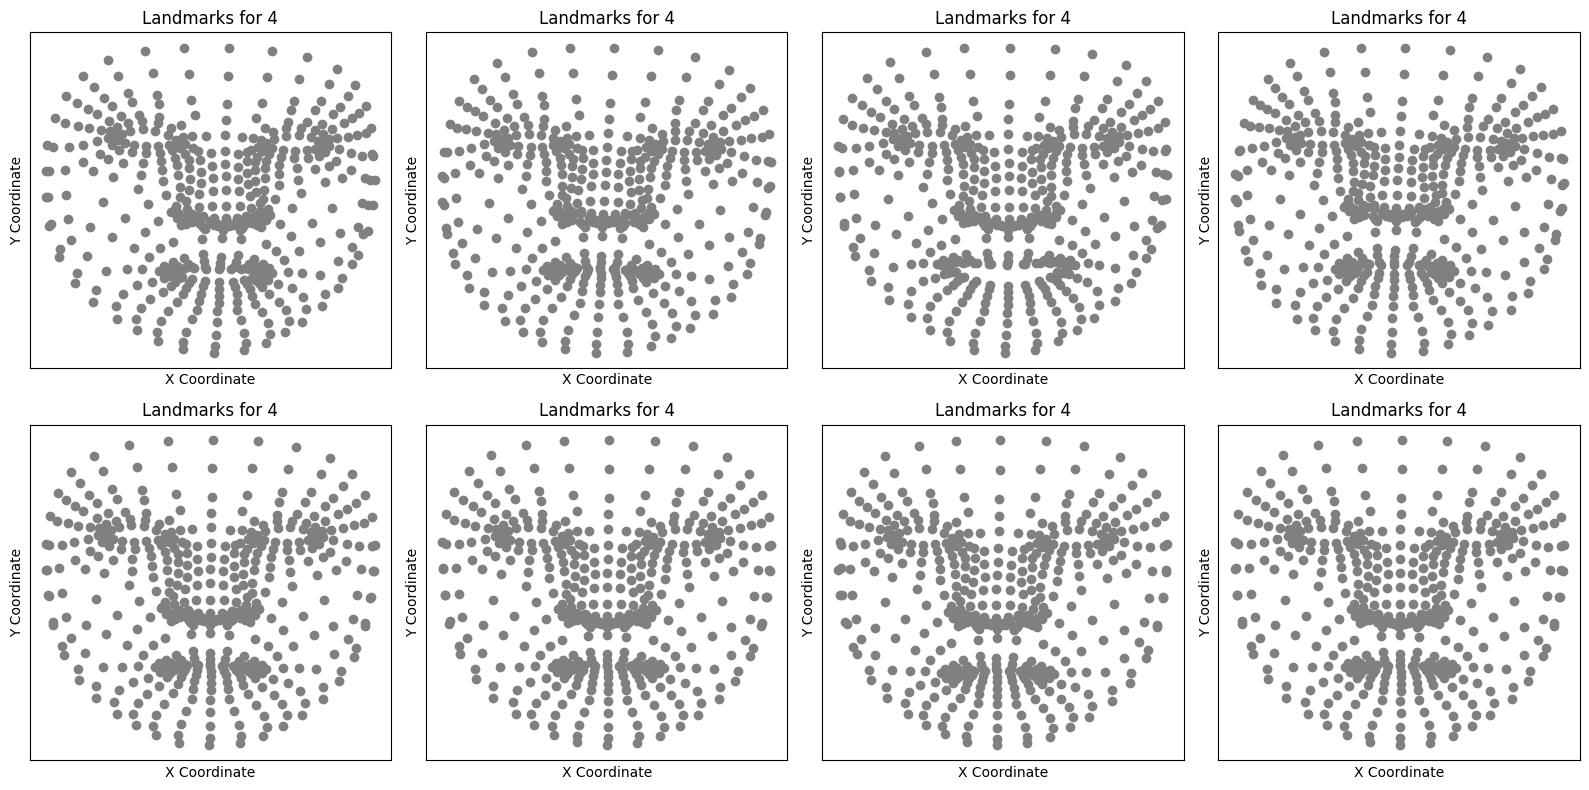

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

first_8_landmarks = X_train_features[:8]
first_8_labels = y_train_labels[:8]

fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    landmarks = first_8_landmarks[i]
    label = first_8_labels[i]

    x_coords = landmarks[0::2]
    y_coords = landmarks[1::2]
    y_coords = -y_coords
    ax.scatter(x_coords, y_coords, color='gray')

    ax.set_title(f'Landmarks for {label}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
user_key = get_random_bytes(16)
encrypted_train_templates = encrypt_face_templates(X_train_features, user_key)
for i, j in enumerate(encrypted_train_templates[:11]):
  print(f'AES encrypted face template {i}: {j[:20]}...')

AES encrypted face template 0: b'\x8e\xcd\x0c}>\x97p\xe3\x8eM\xa8d8\xe3e\xe2`\xe0\xa5Z'...
AES encrypted face template 1: b'\xd1\x00[\x9dO\xa5E*\xf9D~\xb4\xc37\x07L\x97\xfd\x98_'...
AES encrypted face template 2: b'\x92\xb4\xb9w\x00\xd7^\xdee8.H:}|\xe8\x98\x02\x07Y'...
AES encrypted face template 3: b'\xad\x1d\x84\xbe=$3\xf5\xbb\xe2q9\xa5\xd8bg=\xa6h\x04'...
AES encrypted face template 4: b'\xc6\r\\\x10s\x86\x82\xf7#\xdc\xb7\x01d8-\x81\xa7\xd2,\xd8'...
AES encrypted face template 5: b'\xc3\xc0I\xe1c\x8d[\xce\xacy_@\xec\x98\x1d\xbe\xef\x1fmf'...
AES encrypted face template 6: b'\xeff\x1b+#\xe8\x82\xb8q\xd8g\x9cA\x0c\x086 {\x8ai'...
AES encrypted face template 7: b'\xc3\xc0I\xe1c\x8d[\xce\xacy_@\xec\x98\x1d\xbe\xef\x1fmf'...
AES encrypted face template 8: b"$'\xf3\x8e\xe2\xe4\xea\x0b\xae\x8b\x83+\x12\xf0o\xcd?;X\t"...
AES encrypted face template 9: b'0w\xedP\xde\xf8B\x15R\xe9*\xbd\x9d\xba\x16\x9e\xc6\xc3\x92\x80'...
AES encrypted face template 10: b'\xd6\r\x11Z\x87Y\x97\xf0\xaa\xe9Vs\x0e

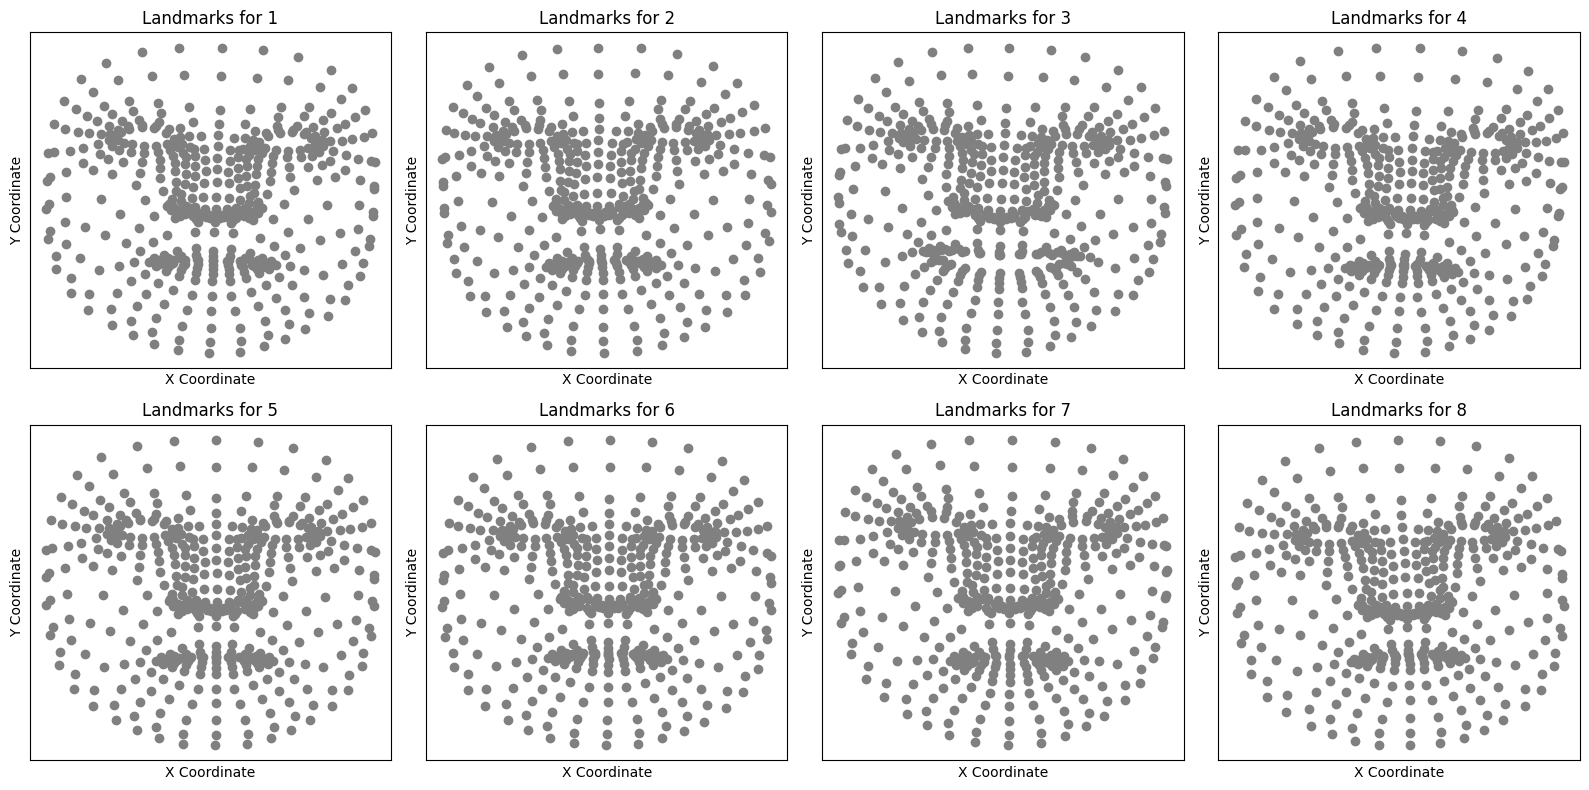

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

first_8_landmarks = X_test_features[:8]
first_8_labels = y_test_labels[:8]

fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    landmarks = first_8_landmarks[i]
    label = first_8_labels[i]

    x_coords = landmarks[0::2]
    y_coords = landmarks[1::2]
    y_coords = -y_coords

    ax.scatter(x_coords, y_coords, color='gray')

    ax.set_title(f'Landmarks for {i+1}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)

plt.tight_layout()
plt.show()

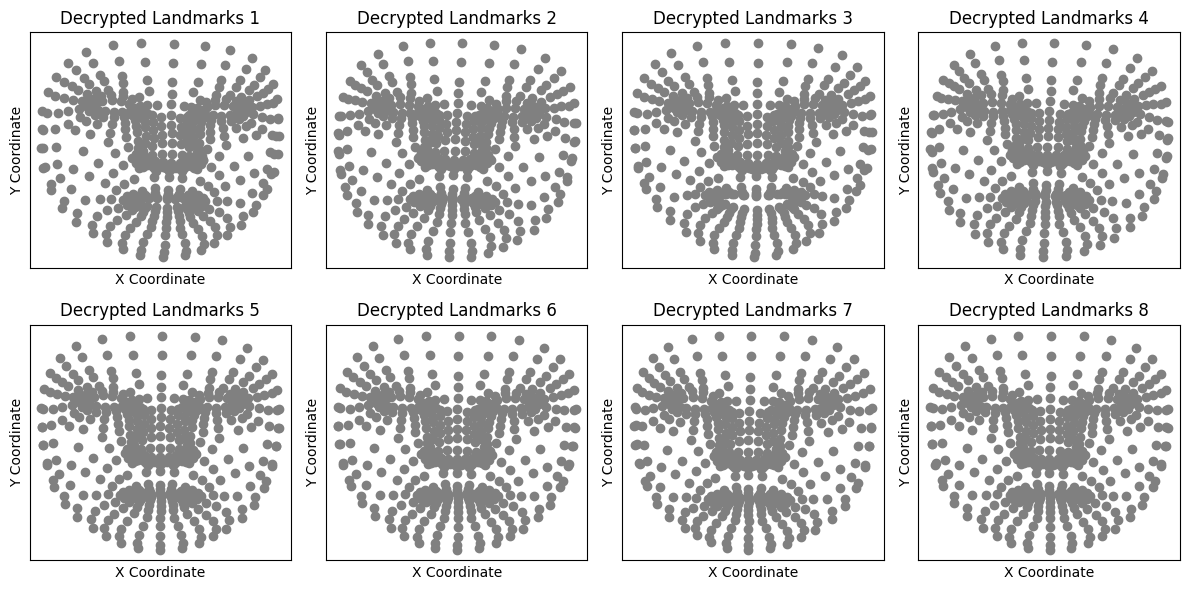

Subject: subject01, min-threshold: 99.83009434765216
10 99.83009434765216


In [ ]:
test_features = X_test_features[0]
test_label = y_test_labels[0]

match_result, threshold, _ = decrypt_and_match(test_features, encrypted_train_templates, user_key, 1)
matched_label = subject_names[int(match_result/11)+1]
print(f"Subject: {matched_label}, min-threshold: {threshold}")
print(match_result, threshold)

In [ ]:
avg_threshold = 0
for test_features in X_test_features:
  match_result, threshold, _ = decrypt_and_match(test_features, encrypted_train_templates, user_key)
  matched_label = subject_names[int(match_result/11)+1]
  avg_threshold += threshold
  print(f"Subject: {matched_label}, min-threshold: {threshold}")

print(avg_threshold/len(X_test_features))

Subject: subject01, min-threshold: 99.83009434765216
Subject: subject06, min-threshold: 100.2358515292201
Subject: subject06, min-threshold: 126.22080667735082
Subject: subject01, min-threshold: 68.38031263964203
Subject: subject09, min-threshold: 142.52178063646355
Subject: subject01, min-threshold: 109.80461047810581
Subject: subject01, min-threshold: 44.93006791691717
Subject: subject07, min-threshold: 62.92436163401481
Subject: subject07, min-threshold: 64.18966023922742
Subject: subject01, min-threshold: 127.01230387294179
Subject: subject06, min-threshold: 96.348391588371
Subject: subject09, min-threshold: 229.96182156228045
Subject: subject01, min-threshold: 80.9571494281838
Subject: subject01, min-threshold: 131.02639893901963
Subject: subject09, min-threshold: 168.18501454735008
Subject: subject09, min-threshold: 128.87201583925594
Subject: subject09, min-threshold: 128.87201583925594
Subject: subject09, min-threshold: 188.0726506346746
Subject: subject01, min-threshold: 113.5